In [5]:
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

import numpy as np
import scipy
from scipy.sparse import csr_matrix, lil_matrix
from scipy.special import gamma
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from findiff import FinDiff, Identity, PDE, BoundaryConditions
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
from pathlib import Path


In [16]:
os.getcwd()

'/Users/azhir/Documents/NeuralInterpolation'

In [13]:
### All stuff just to check path stuff 
os.chdir("../../NeuralInterpolation/")

FileNotFoundError: [Errno 2] No such file or directory: '../../NeuralInterpolation/'

In [18]:
# basically we need to add the path to the models folder
print(os.getcwd())
from models.siren import Siren

/Users/azhir/Documents/NeuralInterpolation


In [19]:
'''
# Code I was using before, does't generalise well

if os.getcwd().endswith("NeuralInterpolation") == 'False':
    os.chdir("../../NeuralInterpolation/")
from models.siren import Siren

'''

'\n# Code I was using before, does\'t generalise well\n\nif os.getcwd().endswith("NeuralInterpolation") == \'False\':\n    os.chdir("../../NeuralInterpolation/")\nfrom models.siren import Siren\n\n'

# Gaussian Activation Functions in a Deep Learning Framework
This code run on a spare data-set and infers the missing data from that spare data. By integrating gaussain processes with deep learning, we will be able to know the uncertainty of our inference. I.e. if you have an MRI a spase under-sampled MRI signal, you can now reconstruct the signal to a higher resolution and know the uncertainty at each given point, telling you the possible other reconstructions. 

Gaussian process regression can turn non-uniform and undersampled diffusion MRI data into diffusion spectrum imaging. Gaussian proccesses have superior interpolation capabilities and avoid smoothing issues like current deep learning architectures, their major limitation is they do not scale. This methodology allows guassian proccesses to scale to an arbitary domain, which could unlock accelerated real-time reconstruction on sparse datasets. 

In [20]:
current_working_directory = Path.cwd()
# print output to the console
print(current_working_directory.parent.absolute())

/Users/azhir/Documents


In [21]:
os.getcwd() 

'/Users/azhir/Documents/NeuralInterpolation'

Generate a synthetic Gaussian random field by solving the SPDE
\begin{align}
(\kappa^2 - \Delta) f = \mathcal{W}.
\end{align}

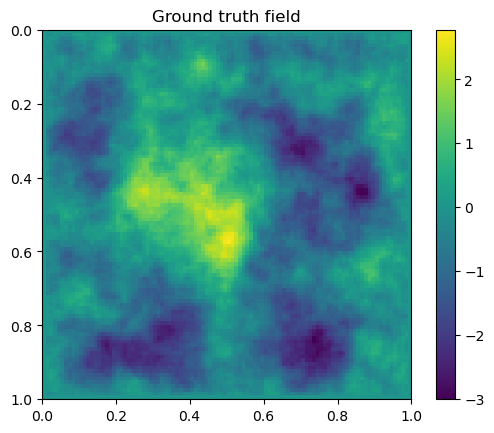

In [15]:
d = 2
ls = 0.15
nu = 1
amp = 1.1
kappa = np.sqrt(2*nu) / ls
q = ((4*np.pi)**(d/2)*kappa**(2*nu)*gamma(nu+d/2))/gamma(nu)
grid_size = 100

x = y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y, indexing='ij')
X_test = np.stack([X.flatten(), Y.flatten()], axis=1)

shape = (grid_size, grid_size)
dx = x[1]-x[0]
dy = y[1]-y[0]

# Set LHS
diff_op = kappa**2 * Identity() - FinDiff(0, dx, 2) - FinDiff(1, dy, 2)

# Set RHS
np.random.seed(0)
W = (1/np.sqrt(dx*dy)) * np.sqrt(q) * amp * np.random.randn(*shape)

# Set boundary conditions (zero-Dirichlet)
bc = BoundaryConditions(shape)
bc[0, :] = 0
bc[-1,:] = 0
bc[:, 0] = 0
bc[:, -1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()

# Plot solution
plt.imshow(u, extent=[0,1,1,0])
plt.colorbar()
plt.title('Ground truth field')
plt.show()

Sample random points for observation

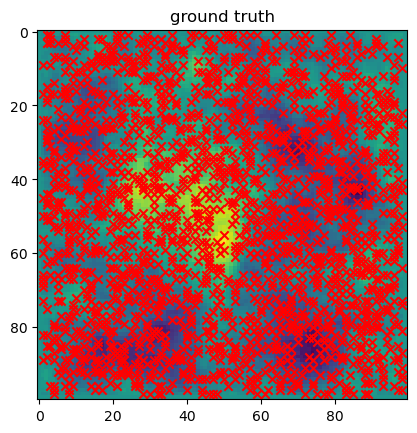

In [16]:
num_obs = 2000
obs_noise = 0

# Get observations at random locations
rng = np.random.default_rng(0)
x_idxs = y_idxs = np.arange(grid_size)
X_idxs, Y_idxs = np.meshgrid(x_idxs[1:-1], y_idxs[1:-1], indexing='ij')
all_idxs = np.stack([X_idxs.flatten(), Y_idxs.flatten()], axis=1)
idxs = rng.choice(all_idxs, num_obs, replace=False)
obs_dict = {tuple(idx): u[tuple(idx)]+obs_noise*np.random.randn() for idx in idxs}

# Plot results
plt.imshow(u)
plt.title('ground truth')
plt.scatter(idxs[:,1], idxs[:,0], c='r', marker='x')

In [17]:
# Create pytorch dataloader
X = list(obs_dict.keys())
Y = list(obs_dict.values())
X = np.array(X)
Y = np.array(Y)
tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(Y)

my_dataset = TensorDataset(tensor_x/100, tensor_y[:,None]) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=256, shuffle=True) # create your dataloader


### For all systems:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [25]:
def train_model(model, dataloader, optim, num_epochs=200):
    for epoch in range(num_epochs):
        epoch_loss = 0
        N = 0
        for i, data in enumerate(dataloader):
            model_input, ground_truth = data
            model_input, ground_truth = model_input.to(device), ground_truth.to(device)
            model_output = model(model_input)    
            loss = ((model_output - ground_truth)**2).mean()
            bs = model_input.shape[0]
            N += bs
            epoch_loss += loss * bs
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_loss /= N
        print(f"Epoch {epoch}: loss {epoch_loss}")


def plot_predictions(model, model_name: str, vmin=-3, vmax=3):
    X_test = torch.Tensor(all_idxs).to(device)
    model_output = model(X_test/100)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    divider1 = make_axes_locatable(ax1)
    im1 = ax1.imshow(u, extent=[0,1,1,0], vmin=vmin, vmax=vmax)
    ax1.set_title('Ground truth')
    cax1 = divider1.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    divider2 = make_axes_locatable(ax2)
    im2 = ax2.imshow(model_output.reshape(98,98).cpu().detach().numpy(), extent=[0,1,1,0], vmin=vmin, vmax=vmax)
    ax2.set_title(model_name + ' output')
    cax2 = divider2.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im2, cax=cax2, orientation='vertical')


# SIREN experiment

In [26]:
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)

img_siren.to(device)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [27]:
num_epochs = 200
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

In [28]:
train_model(img_siren, my_dataloader, optim, num_epochs)

Epoch 0: loss 0.04902328923344612
Epoch 1: loss 0.030325893312692642
Epoch 2: loss 0.02139318734407425
Epoch 3: loss 0.01332420390099287
Epoch 4: loss 0.013404762372374535
Epoch 5: loss 0.008787771686911583
Epoch 6: loss 0.00814030971378088
Epoch 7: loss 0.006650389172136784
Epoch 8: loss 0.004446813836693764
Epoch 9: loss 0.0039952886290848255
Epoch 10: loss 0.004131917376071215
Epoch 11: loss 0.0038659609854221344
Epoch 12: loss 0.00423269160091877
Epoch 13: loss 0.0035406879615038633
Epoch 14: loss 0.0030410229228436947
Epoch 15: loss 0.0031037230510264635
Epoch 16: loss 0.002259769244119525
Epoch 17: loss 0.002163003431633115
Epoch 18: loss 0.0020124055445194244
Epoch 19: loss 0.0018572971457615495
Epoch 20: loss 0.0020713647827506065
Epoch 21: loss 0.0020731156691908836
Epoch 22: loss 0.001494088675826788
Epoch 23: loss 0.001821835176087916
Epoch 24: loss 0.0016196464421227574
Epoch 25: loss 0.0013532296288758516
Epoch 26: loss 0.0015393326757475734
Epoch 27: loss 0.00143602280877

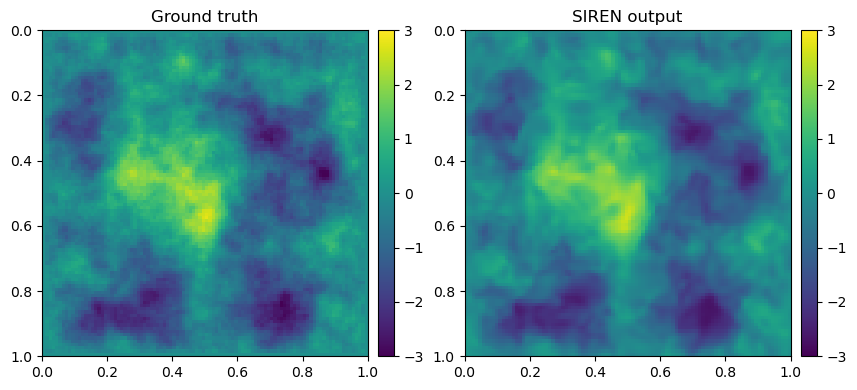

In [29]:
plot_predictions(img_siren, "SIREN")

# Vanilla MLP

In [30]:
from models.mlp import MultilayerPerceptron


mlp = MultilayerPerceptron(in_features=2, out_features=1, hidden_features=256, hidden_layers=3)
mlp.to(device)

num_epochs = 500
optim = torch.optim.Adam(lr=1e-4, params=mlp.parameters())

train_model(mlp, my_dataloader, optim, num_epochs)

Epoch 0: loss 0.09506145864725113
Epoch 1: loss 0.10191686451435089
Epoch 2: loss 0.09467299282550812
Epoch 3: loss 0.10166982561349869
Epoch 4: loss 0.08730437606573105
Epoch 5: loss 0.09491273015737534
Epoch 6: loss 0.09321366995573044
Epoch 7: loss 0.10272052884101868
Epoch 8: loss 0.09199491143226624
Epoch 9: loss 0.09570024907588959
Epoch 10: loss 0.08120796084403992
Epoch 11: loss 0.09294073283672333
Epoch 12: loss 0.08450008183717728
Epoch 13: loss 0.08839540183544159
Epoch 14: loss 0.09159842133522034
Epoch 15: loss 0.10591180622577667
Epoch 16: loss 0.07866448163986206
Epoch 17: loss 0.08111199736595154
Epoch 18: loss 0.0832415223121643
Epoch 19: loss 0.09156087040901184
Epoch 20: loss 0.07756231725215912
Epoch 21: loss 0.07301819324493408
Epoch 22: loss 0.08550361543893814
Epoch 23: loss 0.06981175392866135
Epoch 24: loss 0.07347403466701508
Epoch 25: loss 0.07172808051109314
Epoch 26: loss 0.06720074266195297
Epoch 27: loss 0.07168755680322647
Epoch 28: loss 0.07113074511289

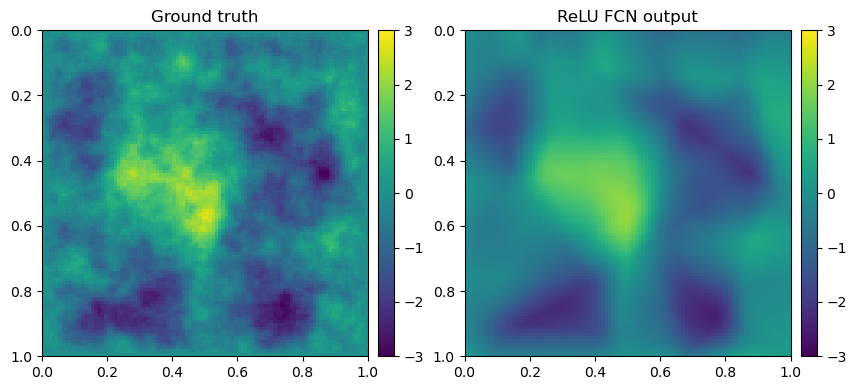

In [31]:
plot_predictions(mlp, "ReLU FCN")

# Positional encoding

In [32]:
from models.mlp import PositionalEncoding

In [33]:
#from models.mlp import PositionalEncoding


pe = PositionalEncoding(in_features=2, mapping_size=256, out_features=1, hidden_features=256, hidden_layers=3)
pe.to(device)

PositionalEncoding(
  (input_layer): Linear(in_features=512, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [34]:

num_epochs = 500
optim = torch.optim.Adam(lr=1e-4, params=pe.parameters())

train_model(pe, my_dataloader, optim, num_epochs)

Epoch 0: loss 0.12420638650655746
Epoch 1: loss 0.11619824916124344
Epoch 2: loss 0.06974155455827713
Epoch 3: loss 0.05716125667095184
Epoch 4: loss 0.04241350665688515
Epoch 5: loss 0.03130252659320831
Epoch 6: loss 0.02405153214931488
Epoch 7: loss 0.022052116692066193
Epoch 8: loss 0.0193009115755558
Epoch 9: loss 0.018256761133670807
Epoch 10: loss 0.018560800701379776
Epoch 11: loss 0.015532665885984898
Epoch 12: loss 0.014978224411606789
Epoch 13: loss 0.01527117844671011
Epoch 14: loss 0.014009078964591026
Epoch 15: loss 0.012675981037318707
Epoch 16: loss 0.012531349435448647
Epoch 17: loss 0.010960942134261131
Epoch 18: loss 0.00994483195245266
Epoch 19: loss 0.008516868576407433
Epoch 20: loss 0.008384687826037407
Epoch 21: loss 0.008853571489453316
Epoch 22: loss 0.008358674123883247
Epoch 23: loss 0.008275419473648071
Epoch 24: loss 0.007779736537486315
Epoch 25: loss 0.0086462227627635
Epoch 26: loss 0.007825721986591816
Epoch 27: loss 0.007796939928084612
Epoch 28: loss 

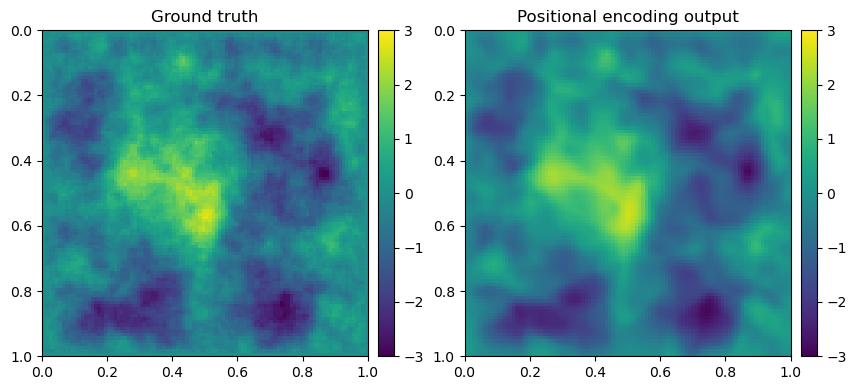

In [35]:
plot_predictions(pe, "Positional encoding")

In [ ]:
from models.gpr import ExactGPR
import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel

likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel = ScaleKernel(MaternKernel(ard_num_dims=2, nu=1.5))
model = ExactGPR(tensor_x/100, tensor_y, likelihood, kernel=kernel)
model.covar_module.base_kernel.register_constraint("raw_lengthscale",
                                                    gpytorch.constraints.Interval(1e-5, 1)
                                                    )

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(tensor_x/100)
    # Calc loss and backprop gradients
    loss = -mll(output, tensor_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale[0,0].item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

    

Iter 1/100 - Loss: 0.963   lengthscale: 0.500   noise: 0.693
Iter 2/100 - Loss: 0.926   lengthscale: 0.475   noise: 0.644
Iter 3/100 - Loss: 0.890   lengthscale: 0.450   noise: 0.598
Iter 4/100 - Loss: 0.854   lengthscale: 0.425   noise: 0.554
Iter 5/100 - Loss: 0.816   lengthscale: 0.401   noise: 0.513
Iter 6/100 - Loss: 0.776   lengthscale: 0.377   noise: 0.474
Iter 7/100 - Loss: 0.738   lengthscale: 0.354   noise: 0.437
Iter 8/100 - Loss: 0.700   lengthscale: 0.331   noise: 0.403
Iter 9/100 - Loss: 0.660   lengthscale: 0.309   noise: 0.370
Iter 10/100 - Loss: 0.620   lengthscale: 0.288   noise: 0.340
Iter 11/100 - Loss: 0.582   lengthscale: 0.267   noise: 0.312
Iter 12/100 - Loss: 0.544   lengthscale: 0.248   noise: 0.285
Iter 13/100 - Loss: 0.507   lengthscale: 0.230   noise: 0.261
Iter 14/100 - Loss: 0.470   lengthscale: 0.214   noise: 0.238
Iter 15/100 - Loss: 0.434   lengthscale: 0.199   noise: 0.218
Iter 16/100 - Loss: 0.404   lengthscale: 0.185   noise: 0.198
Iter 17/100 - Los

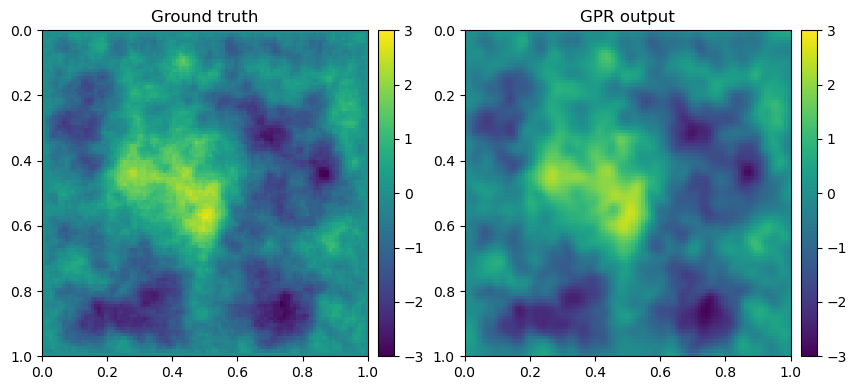

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_test = torch.Tensor(all_idxs)
    pred_f = model(X_test/100)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    divider1 = make_axes_locatable(ax1)
    im1 = ax1.imshow(u, extent=[0,1,1,0], vmin=-3, vmax=3)
    ax1.set_title('Ground truth')
    cax1 = divider1.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    divider2 = make_axes_locatable(ax2)
    im2 = ax2.imshow(pred_f.mean.reshape(98,98).cpu().detach().numpy(), extent=[0,1,1,0], vmin=-3, vmax=3)
    ax2.set_title('GPR output')
    cax2 = divider2.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im2, cax=cax2, orientation='vertical')

# Matern Activation in Deep Learning

In [8]:
LR = 0.02 #learning rate
n_epochs = 2000
batch_size = 400 #full batch

MC = 100 #number of MC dropout samples
dropout = 0.2

In [9]:
def matern_activation(x, nu_ind=2, ell=0.5):
    """
      x: Input to the activation function
      device: A torch.device object
      nu_ind: Index for choosing Matern smoothness (look at nu_list below)
      ell: Matern length-scale, only 0.5 and 1 available with precalculated scaling coefficients
    """
    nu_list = [1/2, 3/2, 5/2, 7/2, 9/2] #list of available smoothness parameters
    nu = torch.tensor(nu_list[nu_ind]) #smoothness parameter
    lamb =  torch.sqrt(2*nu)/ell #lambda parameter
    v = nu+1/2
    # Precalculated scaling coefficients for two different lengthscales (q divided by Gammafunction at nu + 0.5)
    ell05A = [4.0, 19.595917942265423, 65.31972647421809, 176.69358285524189, 413.0710073859664]
    ell1A = [2.0, 4.898979485566356, 8.16496580927726, 11.043348928452618, 12.90846898081145]
    if ell == 0.5:
        A = ell05A[nu_ind]
    if ell == 1:
        A = ell1A[nu_ind]
    y = A*torch.sign(x)*torch.abs(x)**(v-1)*torch.exp(-lamb*torch.abs(x))
    y[x<0] = 0 # Values at x<0 must all be 0
    return y


In [10]:
# reference number of input, output and hidden width and hidden layers
# mlp = MultilayerPerceptron(in_features=2, out_features=1, hidden_features=256, hidden_layers=3)


In [11]:
class Deep_Matern(nn.Module):
    def __init__(self):
        super(Deep_Matern, self).__init__()

        # Fully conencted layers
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = matern_activation(self.fc1(x))
        x = matern_activation(self.fc2(x))
        x = matern_activation(self.fc3(x))

        return x

In [18]:
dl_gp = Deep_Matern().to(device)
optim = torch.optim.Adam(lr=1e-4, params= dl_gp.parameters())

In [19]:
num_epochs = 500
train_model(dl_gp, my_dataloader, optim, num_epochs)

NameError: name 'train_model' is not defined